# custom_paired_dataset으로 2차 학습의 추가학습

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1qn4RCOrPN2SUC05OQ7VAi7RM4W3Yhdla#scrollTo=ikvsOikDtfiT)

<4.pix2pix_v2(75epoch).ipynb>의 2차 학습을 같은 데이터셋으로 에포크 이어서 추가학습(~125epoch)

다른 구글 계정을 사용해 마운트하는 구글 드라이브 역시 달라진다면 
1. '/content/drive/MyDrive/pix2pix/' 에 custom_paired_dataset.zip을 업로드
2. /content/drive/MyDrive/pix2pix/trained_model'에 지난번까지 학습시킨 모델, Pix2Pix_Generator_V2(75e).pt와 Pix2Pix_Discriminator_V2(75e).pt를 업로드
하고 진행

---
런타임 끊김 방지를 위해 f12 개발자 도구에 밑에 코드 넣고 enter

function ClickConnect(){ console.log("Working"); document.querySelector("colab-toolbar-button").click() }setInterval(ClickConnect, 360000)

---

학습에 사용한 데이터셋은 <2.create_custom_paired_dataset.ipynb>에서 구축한 약 8500쌍의 paired data로 구성됨. 

colab 노트북의 경우 런타임 끊김을 방지하더라도 할당된 gpu 런타임 이상을 사용할 수 없음. 런타임이 종료될 경우 그동안 돌아간 모델이 날아갈 수 있어 25epoch씩 나눠 실행함. 25epoch마다 약 2시간 30분이 소요됨.

~100epoch
~125epoch





# 0.구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.W&B 사용하기 위해 로그인

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 31.9 MB/s 
     |████████████████████████████████| 157 kB 68.3 MB/s 
     |████████████████████████████████| 181 kB 67.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 157 kB 73.2 MB/s 
     |████████████████████████████████| 157 kB 74.7 MB/s 
     |████████████████████████████████| 157 kB 76.7 MB/s 
     |████████████████████████████████| 157 kB 73.8 MB/s 
     |████████████████████████████████| 156 kB 71.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b5565b2f386e17d14054446f0b7bc5967fc431613ddb707cecd98e68376433a0
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
%cd /content/drive/MyDrive/pix2pix

/content/drive/MyDrive/pix2pix


In [4]:
import wandb
!wandb login  #api 사용해 로그인 필요

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project="coloring-page")  #wandb web 서버와 연결

wandb: Currently logged in as: mj22. Use `wandb login --relogin` to force relogin


# 2.필요한 라이브러리 불러오기

In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

# 3.데이터셋 불러오기 및 확인

In [ ]:
!unzip '/content/drive/MyDrive/pix2pix/custom_paired_dataset.zip' -d '/content/'

In [8]:
print("학습 데이터셋 A와 B의 개수:", len(next(os.walk('/content/content/custom_paired_dataset'))[2]))

학습 데이터셋 A와 B의 개수: 8699


이미지 크기: (512, 256)


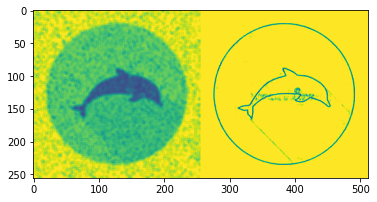

In [9]:
image = Image.open('/content/content/custom_paired_dataset/b(1)10.png')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

### 3-1.오류수정 
모델의 데이터셋의 데이터 형식이 rgb여야 하는데 구성한 custom_paired_dataset이 gray images였음.

폴더 내의 gray images를 일괄적으로 rgb images로 바꿔줌
/content/content/ 내에 새폴더(rgb_custom_paired_dataset)을 만들고 실행

In [11]:
import os
from PIL import Image

ORIGIN_PATH = "/content/content/custom_paired_dataset/"
DESTIN_PATH = "/content/content/rgb_custom_paired_dataset/"

for filename in os.listdir(ORIGIN_PATH):                                                                                                                                                                
    img = Image.open(ORIGIN_PATH + filename).convert("RGB")                                                                                                                                                
    img.save(DESTIN_PATH + filename) 

# 4.데이터셋 클래스 정의

In [12]:
import cv2 

%cd /content/content/

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="rgb_custom_paired_dataset"):
        self.transform = transforms_

        self.files = sorted(glob.glob(os.path.join(root, '/content/content/rgb_custom_paired_dataset') + "/*.png"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반(A: sketch image)
        img_B = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반(B: colored illustration image)       

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

/content/content


In [13]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("data", transforms_=transforms_)  
val_dataset = ImageDataset("data", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
val_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 5.생성자 및 판별자 모델 정의

In [14]:
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [15]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# 6.2차 학습시킨 모델 불러오기




In [16]:
%cd /content/drive/MyDrive/pix2pix/trained_model/

generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("Pix2Pix_Generator_V2(75e).pt"))
discriminator.load_state_dict(torch.load("Pix2Pix_Discriminator_V2(75e).pt"))

generator.eval();
discriminator.eval();

/content/drive/MyDrive/pix2pix/trained_model


#7.2차모델 epoch이어서 학습

### ~100epoch

In [19]:
# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [21]:
%cd /content/drive/MyDrive/pix2pix/v2(100e)

import time

n_epochs = 25 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = (epoch+75) * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    wandb.log({"epoch": epoch+75, "D loss": loss_D.item(), "G pixel loss": loss_pixel.item() , "adv loss" : loss_GAN.item()})
    print(f"[Epoch {epoch+75}/{n_epochs+75}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

%cd /content/drive/MyDrive/pix2pix/trained_model

# 모델 파라미터 저장
torch.save(generator.state_dict(), "Pix2Pix_Generator_V2(100e).pt")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator_V2(100e).pt")
print("Model saved!")

/content/drive/MyDrive/pix2pix/v2(100e)
[Epoch 75/100] [D loss: 0.282330] [G pixel loss: 0.051712, adv loss: 0.19042465090751648] [Elapsed time: 346.00s]
[Epoch 76/100] [D loss: 0.137650] [G pixel loss: 0.041503, adv loss: 0.51030433177948] [Elapsed time: 692.81s]
[Epoch 77/100] [D loss: 0.192630] [G pixel loss: 0.037484, adv loss: 0.7455053329467773] [Elapsed time: 1040.22s]
[Epoch 78/100] [D loss: 0.252164] [G pixel loss: 0.048803, adv loss: 0.9493846893310547] [Elapsed time: 1386.92s]
[Epoch 79/100] [D loss: 0.271601] [G pixel loss: 0.037358, adv loss: 0.3170098066329956] [Elapsed time: 1733.58s]
[Epoch 80/100] [D loss: 0.248373] [G pixel loss: 0.026599, adv loss: 0.25212812423706055] [Elapsed time: 2080.26s]
[Epoch 81/100] [D loss: 0.160344] [G pixel loss: 0.051346, adv loss: 0.35967323184013367] [Elapsed time: 2426.81s]
[Epoch 82/100] [D loss: 0.213414] [G pixel loss: 0.030965, adv loss: 0.7627235054969788] [Elapsed time: 2773.47s]
[Epoch 83/100] [D loss: 0.124149] [G pixel loss: 

### ~125epoch

In [22]:
# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [23]:
%cd /content/drive/MyDrive/pix2pix/v2(125e)

import time

n_epochs = 25 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = (epoch+100) * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    wandb.log({"epoch": epoch+100, "D loss": loss_D.item(), "G pixel loss": loss_pixel.item() , "adv loss" : loss_GAN.item()})
    print(f"[Epoch {epoch+100}/{n_epochs+100}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

%cd /content/drive/MyDrive/pix2pix/trained_model

# 모델 파라미터 저장
torch.save(generator.state_dict(), "Pix2Pix_Generator_V2(125e).pt")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator_V2(125e).pt")
print("Model saved!")

/content/drive/MyDrive/pix2pix/v2(125e)
[Epoch 100/125] [D loss: 0.200195] [G pixel loss: 0.030870, adv loss: 0.353591650724411] [Elapsed time: 348.96s]
[Epoch 101/125] [D loss: 0.158823] [G pixel loss: 0.043500, adv loss: 0.3712104260921478] [Elapsed time: 696.57s]
[Epoch 102/125] [D loss: 0.236576] [G pixel loss: 0.026994, adv loss: 0.35518741607666016] [Elapsed time: 1043.85s]
[Epoch 103/125] [D loss: 0.210483] [G pixel loss: 0.044484, adv loss: 0.36374253034591675] [Elapsed time: 1390.90s]
[Epoch 104/125] [D loss: 0.142876] [G pixel loss: 0.058811, adv loss: 0.32495713233947754] [Elapsed time: 1738.48s]
[Epoch 105/125] [D loss: 0.125204] [G pixel loss: 0.040799, adv loss: 0.5224893689155579] [Elapsed time: 2085.87s]
[Epoch 106/125] [D loss: 0.137717] [G pixel loss: 0.048671, adv loss: 0.45142629742622375] [Elapsed time: 2433.39s]
[Epoch 107/125] [D loss: 0.171087] [G pixel loss: 0.041196, adv loss: 0.4095454216003418] [Elapsed time: 2780.29s]
[Epoch 108/125] [D loss: 0.235052] [G p